### Step - 1: Loading the necessary libraries

In [1]:
import kagglehub
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobile_preprocess
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Step - 2: Download the dataset

In [2]:
path = kagglehub.dataset_download("soumyakushwaha/indian-sign-language-dataset")
def find_data_dir(start_path):
    for root, dirs, files in os.walk(start_path):
        if all(len(d) == 1 and d.isalpha() for d in dirs) and len(dirs) > 5:
            return root
    return None
data_dir = find_data_dir(path)

100%|██████████| 2.82M/2.82M [00:01<00:00, 2.36MB/s]

Extracting files...


### Step - 3: Load the dataset

In [3]:
def load_dataset(data_dir, img_size=(224, 224)):
    images, labels = [], []
    for folder in sorted(os.listdir(data_dir)):
        folder_path = os.path.join(data_dir, folder)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(folder)
    return np.array(images), np.array(labels)

images, labels = load_dataset(data_dir)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42)

### Step - 4: Preprocessing

In [4]:
X_train_mobile = mobile_preprocess(X_train.copy())
X_test_mobile = mobile_preprocess(X_test.copy())
X_train_resnet = resnet_preprocess(X_train.copy())
X_test_resnet = resnet_preprocess(X_test.copy())

### Step - 5: Data Augmentation

In [5]:
aug = ImageDataGenerator(
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=True
)
aug.fit(X_train)

### Step - 6: Build model

In [6]:
def build_model(base_fn, input_shape, num_classes, fine_tune_at=50, lr=1e-4, dropout_rate=0.5):
    base = base_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = True
    for layer in base.layers[:fine_tune_at]:
        layer.trainable = False

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (224, 224, 3)
num_classes = len(np.unique(y_train))
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

### Step - 7: Train ResNet50

In [7]:
print("\n🚀 Training ResNet50...")
resnet_model = build_model(ResNet50, input_shape, num_classes, fine_tune_at=80, lr=1e-4)
history_resnet = resnet_model.fit(
    aug.flow(X_train_resnet, y_train, batch_size=16),
    validation_data=(X_test_resnet, y_test),
    epochs=40,
    callbacks=[early_stop],
    verbose=1
)


🚀 Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 76s 987ms/step - accuracy: 0.0403 - loss: 4.2200 - val_accuracy: 0.1348 - val_loss: 3.1922
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 224ms/step - accuracy: 0.1122 - loss: 3.3377 - val_accuracy: 0.1631 - val_loss: 2.8527
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - accuracy: 0.1580 - loss: 2.9533 - val_accuracy: 0.3404 - val_loss: 2.3577
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.2293 - loss: 2.4978 - val_accuracy: 0.4681 - val_loss: 1.9219
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.3876 - loss: 2.1092 - val_accuracy: 0.5035 - val_loss: 1.6114
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.5449 - loss: 1.5916 - val_accuracy: 0.6170 - val_loss: 1.1445
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 246ms/step - accuracy: 0.6568 - loss: 1.2585 - val_accuracy: 0.7234 - val_loss: 0.8750
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 245ms/step - accuracy: 0.7275 - loss: 0.9701 - val_accuracy: 

### Step - 8: Train MobileNetV2

In [8]:
print("\n🚀 Training MobileNetV2...")
mobilenet_model = build_model(MobileNetV2, input_shape, num_classes, fine_tune_at=50, lr=1e-4)
history_mobile = mobilenet_model.fit(
    aug.flow(X_train_mobile, y_train, batch_size=16),
    validation_data=(X_test_mobile, y_test),
    epochs=40,
    callbacks=[early_stop],
    verbose=1
)


🚀 Training MobileNetV2...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 69s 841ms/step - accuracy: 0.0327 - loss: 4.1834 - val_accuracy: 0.0496 - val_loss: 3.3350
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 43s 185ms/step - accuracy: 0.0923 - loss: 3.3751 - val_accuracy: 0.1135 - val_loss: 3.1652
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 208ms/step - accuracy: 0.0910 - loss: 3.2989 - val_accuracy: 0.1348 - val_loss: 3.0854
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.0812 - loss: 3.0261 - val_accuracy: 0.1489 - val_loss: 3.0021
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.1413 - loss: 2.9407 - val_accuracy: 0.1631 - val_loss: 2.8993
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.2215 - loss: 2.7289 - val_accuracy: 0.2199 - val_loss: 2.7665
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.2220 - loss: 2.7108 - val_accuracy: 0.2553 - val_loss: 2.6168
Epoch 8/40
36/36 ━━━━━━━━

### Step - 9: Evaluate the models

In [9]:
def evaluate_model(model, name, X_train, y_train, X_test, y_test):
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n📊 {name} Results")
    print(f"✅ Training Accuracy: {train_acc * 100:.2f}%")
    print(f"✅ Testing Accuracy:  {test_acc * 100:.2f}%")
    return train_acc, test_acc

acc_resnet_train, acc_resnet_test = evaluate_model(resnet_model, "ResNet50", X_train_resnet, y_train, X_test_resnet, y_test)
acc_mobile_train, acc_mobile_test = evaluate_model(mobilenet_model, "MobileNetV2", X_train_mobile, y_train, X_test_mobile, y_test)


📊 ResNet50 Results
✅ Training Accuracy: 98.93%
✅ Testing Accuracy:  85.11%

📊 MobileNetV2 Results
✅ Training Accuracy: 97.50%
✅ Testing Accuracy:  78.72%


### Step - 10: Plot the graphs

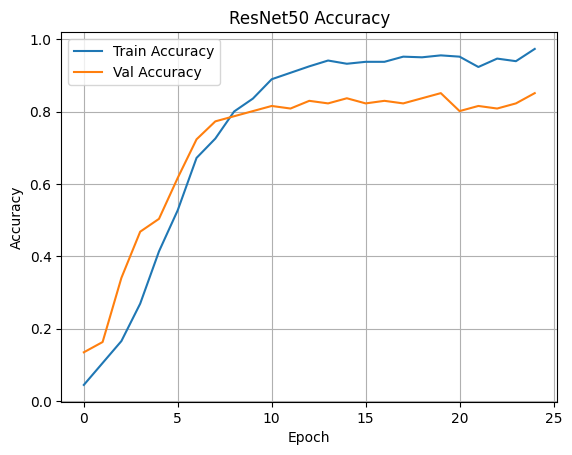

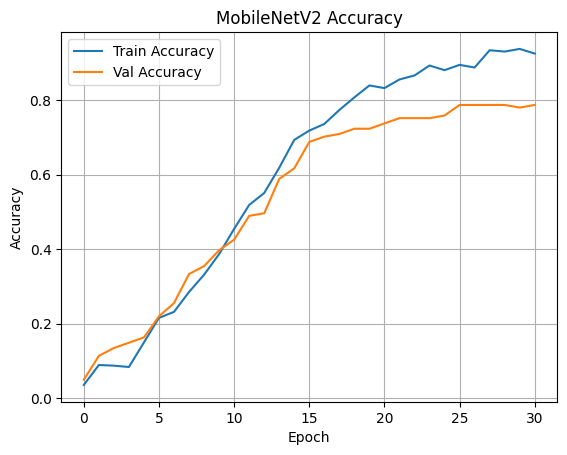

In [10]:
def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()
    print()

plot_history(history_resnet, "ResNet50 Accuracy")
plot_history(history_mobile, "MobileNetV2 Accuracy")